## Desafio 2

Os marcos faciais podem ser marcadores relevantes para identificar emoções de um rosto? Vamos experimentar classificar 3 expressões: felicidade, neutro e surpresa com a base de dados do FER 2013.

Avalie utilizar alinhamento das faces e medidas de aspecto de razão dos olhos e dos lábios.

![](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-4-classificacao-objetos-analise-facial/desafio-2/imagens/Sample-of-the-FER2013-dataset.png?raw=1)


## 1. Requerimentos

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV >= 3.4.3
* Matplotlib >= 3.1.3
* Seaborn >= 0.0.10
* Numpy >= 1.18.1

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [1]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 11697, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 11697 (delta 114), reused 260 (delta 110), pack-reused 11432
Receiving objects: 100% (11697/11697), 1.06 GiB | 29.81 MiB/s, done.
Resolving deltas: 100% (565/565), done.
Checking out files: 100% (576/576), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [2]:
%cd fiap-ml-visao-computacional/aula-4-classificacao-objetos-analise-facial

/content/fiap-ml-visao-computacional/aula-4-classificacao-objetos-analise-facial


### Modelo experimental com marcos faciais e medidas de aspecto de razão

A descrição da face humana por meio de marcos faciais e por medidas de contorno utilizando o aspecto de razão pode ser tornar também uma forma para poder predizer algumas emoções baseada nestas características.

Condição neutra, feliz ou triste influenciam significativamente a distância entre os marcos faciais.

Vamos realizar um pequeno experimento para utilizar as medidas da boa, nariz, olhos e sombrancelhas para estebelecer um modelo que seja capaz de identificar as condições: neutra, felicidade e tristeza.

Inicialmente vamos extrair as seguintes informações:

* Retas entre o ponto central da face e os elementos da face (olhos, sombrancelhas, nariz e boca)
* Calcular medida de aspecto de razão dos olhos e da boca. Em relação ao MAR (Mouth Aspect Ratio), a ideia é a mesma do EAR, porém com mais pontos.

Vamos reunir todos os dados em um dataframe para posteriormente utilizarmos num treinamento de modelo.

Importação das bibliotecas.

In [3]:
import numpy as np
import pandas as pd

import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

import seaborn as sns

import cv2

import math

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.svm import SVC

#Exibição na mesma tela do Jupyter
%matplotlib inline

import dlib

from scipy.spatial import distance as dist

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

Vamos definir os pontos dos marcos faciais. Neste caso ampliamos um pouco mais para considerar o lábio exterior e o inferior, que nos serão úteis no cálculo do MAR (Mouth Aspect Ratio), semelhante ao EAR (Eye Aspect Ratio) que vimos em aula.

In [4]:
FACE_COMPLETA = list(range(0, 68))
SOMBRANCELHA_DIREITA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36, 42))
OLHO_ESQUERDO = list(range(42, 48))
NARIZ = list(range(27, 35))
LABIO = list(range(48, 61))
LABIO_EXTERIOR = list(range(48, 61))
LABIO_INTERIOR = list(range(60, 68))
MANDIBULA = list(range(0, 17))

Vamos também definir o caminho do do classificador Dlib.

In [5]:
classificador_68_path = "modelos/shape_predictor_68_face_landmarks.dat"
classificador_dlib_68 = dlib.shape_predictor(classificador_68_path)

detector_face_dlib = dlib.get_frontal_face_detector()

Trouxemos a função ```ear``` da aula anterior.

In [6]:
def ear(pontos_olho):
    
    a = dist.euclidean(pontos_olho[1], pontos_olho[5])
    b = dist.euclidean(pontos_olho[2], pontos_olho[4])
    c = dist.euclidean(pontos_olho[0], pontos_olho[3])

    medida_ear = (a + b) / (2.0 * c)

    return medida_ear

A função ```mar``` calcula o aspecto de razão dos lábios, utilizando o mesmo princípio do EAR. Calculamos a distância entre os pontos verticais, ao todo 3, e dividimos pela medida horizontal. Como são 3 medidas verticais, equilibramos com o mesmo valor no denominador, como fizemos no ```ear```. 

Nesta [imagem](https://www.researchgate.net/figure/Mouth-aspect-ratio-MAR_fig3_334168196#:~:text=A%20quantity%20called%20the%20mouth,%5B19%5D%20.%20...) há uma referência para o cálculo do MAR, porém optei por fazer diferente, utilizando o lábio interno por descrever melhor a abertura e fechamento da boca. Por isso que o número de retas verticais aplicados são 3 e não 5.

In [7]:
def mar(pontos_boca):

    a = dist.euclidean(pontos_boca[1], pontos_boca[7])
    b = dist.euclidean(pontos_boca[2], pontos_boca[6])
    c = dist.euclidean(pontos_boca[3], pontos_boca[5])
    
    d = dist.euclidean(pontos_boca[0], pontos_boca[4])

    medida = (a + b + c) / (3.0 * d)

    return medida

Agora a extração de linhas e aspecto de razão.

In [8]:
def extrair_caracteristicas_face(imagem, emotion='', anotar_imagem=True):
  
  retas = []

  face = detector_face_dlib(imagem, 1)
  
  if len(face) == 0:
    return None, None

  if anotar_imagem:
    imagem_anotada = imagem.copy()

  pontos_x = []
  pontos_y = []
  pontos = []

  shape = classificador_dlib_68(imagem, face[0])

  for i in range(0, 68):
 
    pontos_x.append(shape.part(i).x)
    pontos_y.append(shape.part(i).y)
    pontos.append([shape.part(i).x, shape.part(i).y])

  pontos = np.matrix(pontos)
    
  ponto_x_medio = np.mean(pontos_x)
  ponto_y_medio = np.mean(pontos_y)
  
  d = {}
  c = 0

  for i, ponto in enumerate(range(0, 68)):
    
    if i in range(0,17):
      continue

    ponto_medio = (ponto_x_medio, ponto_y_medio)
    reta = dist.euclidean(ponto_medio, (pontos_x[i], pontos_y[i]))
    
    retas.append(reta)

    c = c + 1

    d["reta_" + str(c)] = [reta]

    if anotar_imagem:
      imagem_anotada = cv2.line(imagem_anotada, (int(ponto_x_medio), int(ponto_y_medio)), (int(pontos_x[i]), int(pontos_y[i])), (255,255,255), 2)
      pontos_anotacao = cv2.convexHull(pontos[LABIO_INTERIOR])
      cv2.drawContours(imagem_anotada, [pontos_anotacao], 0, (255,255,255), 2)
      pontos_anotacao = cv2.convexHull(pontos[LABIO_EXTERIOR])
      cv2.drawContours(imagem_anotada, [pontos_anotacao], 0, (255,255,255), 2)
      pontos_anotacao = cv2.convexHull(pontos[OLHO_DIREITO])
      cv2.drawContours(imagem_anotada, [pontos_anotacao], 0, (255,255,255), 2)
      pontos_anotacao = cv2.convexHull(pontos[OLHO_ESQUERDO])
      cv2.drawContours(imagem_anotada, [pontos_anotacao], 0, (255,255,255), 2)

  df = pd.DataFrame(d)

  ear_olho_direito = ear(pontos[OLHO_DIREITO])
  ear_olho_esquerdo = ear(pontos[OLHO_ESQUERDO])
  mar_boca = mar(pontos[LABIO_INTERIOR])

  df["ear_d"] = ear_olho_direito
  df["ear_e"] = ear_olho_esquerdo
  df["mar"] = mar_boca

  df["emotion"] = emotion

  if anotar_imagem:
    return imagem_anotada, df
  
  
  if len(retas) != 51:
    return None, None

  return None, df

Vamos inspecionar algumas imagens e desenhar as retas e as medidas de aspecto de razão.

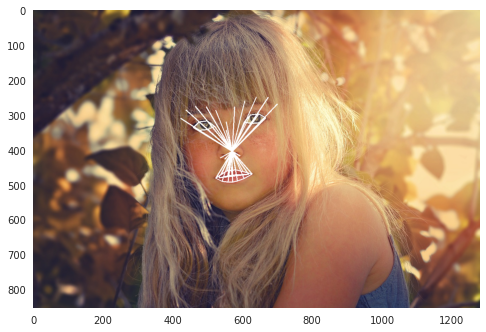

In [9]:
imagem = cv2.imread("imagens/girl.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

imagem_a, df = extrair_caracteristicas_face(imagem, "neutral")
plt.imshow(imagem_a)

Dados obtidos. Temos 51 retas que representam os pontos de cada marco facial e o centro da face.

In [10]:
df

,reta_1,reta_2,reta_3,reta_4,reta_5,reta_6,reta_7,reta_8,reta_9,reta_10,...,reta_46,reta_47,reta_48,reta_49,reta_50,reta_51,ear_d,ear_e,mar,emotion
0,174.778809,177.377836,165.902123,147.345281,126.450465,127.523295,148.727988,169.919746,185.477879,186.87779,...,70.670837,68.694654,80.672447,67.70991,69.670967,70.888787,0.401489,0.391874,0.011684,neutral


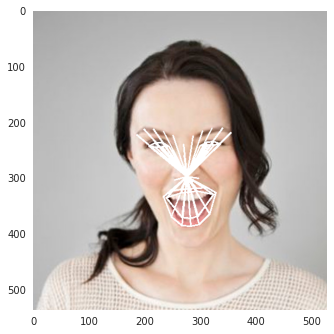

In [12]:
imagem = cv2.imread("imagens/mulher.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

imagem_a, df = extrair_caracteristicas_face(imagem, "neutral")
plt.imshow(imagem_a)

In [13]:
df

,reta_1,reta_2,reta_3,reta_4,reta_5,reta_6,reta_7,reta_8,reta_9,reta_10,...,reta_46,reta_47,reta_48,reta_49,reta_50,reta_51,ear_d,ear_e,mar,emotion
0,117.907741,115.499172,104.885932,92.107993,78.983245,74.595773,87.334718,98.547391,108.496137,112.100008,...,28.419132,30.779099,56.989679,72.890732,74.395604,72.772409,0.20924,0.154766,0.528486,neutral


Para este treinamento, utilizaremos o conjunto de faces [FER 2013](https://datarepository.wolframcloud.com/resources/FER-2013) das quais possuem milhares de exemplos de faces em 7 diferentes emoções, sendo nervoso (angry), nojo (disgust), medo (fear), feliz (happy), neutro (neutral), triste (sad) e surpreso (surprise).

Em nosso teste vamos utilizar apenas 3 emoções: neutro, feliz e surpreso.

O dataset foi organizado abaixo e não é necessário baixar do site original.



In [81]:
!rm -rf dataset-fer-2013-facial-expressions/

In [14]:
!git clone https://github.com/michelpf/dataset-fer-2013-facial-expressions

Cloning into 'dataset-fer-2013-facial-expressions'...
remote: Enumerating objects: 34045, done.
remote: Total 34045 (delta 0), reused 0 (delta 0), pack-reused 34045
Receiving objects: 100% (34045/34045), 52.45 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (35888/35888), done.


Agora vamos preparar as faces para o treinamento. 

Para padronizar as faces, vamos utilizar nossa função de alinhar as faces, assim podemos extrair as características das mesmas regiões faciais e também validamos se o modelo do DLib foi capaz de identificar a face na imagem para extrair os marcos faciais.

Abaixo alguns exemplos de alinhamento.

Vamos removar as faces que não precisamos (todas menos a neutral, happy e surprise).

In [15]:
!rm -rf dataset-fer-2013-facial-expressions/dataset/fear/
!rm -rf dataset-fer-2013-facial-expressions/dataset/angry/
!rm -rf dataset-fer-2013-facial-expressions/dataset/disgust/
!rm -rf dataset-fer-2013-facial-expressions/dataset/sad/

In [16]:
print("Imagens happy: " + str(len(list(glob.glob('dataset-fer-2013-facial-expressions/dataset/happy/*.*')))))
print("Imagens neutral: " + str(len(list(glob.glob('dataset-fer-2013-facial-expressions/dataset/neutral/*.*')))))
print("Imagens surprise: " + str(len(list(glob.glob('dataset-fer-2013-facial-expressions/dataset/surprise/*.*')))))

Imagens happy: 8989
Imagens neutral: 6198
Imagens surprise: 4002


Com as faces alinhadas, agora vamos extrair as características.

In [17]:
features = pd.DataFrame()

expression = None
i = 0
for f in tqdm(glob.glob('dataset-fer-2013-facial-expressions/**/*.jpg', recursive=True)):
  imagem = cv2.imread(f)
  _, features_face = extrair_caracteristicas_face(imagem, f.split("/")[2].lower(), False)
  if features_face is not None:
    features = pd.concat([features, features_face])

100%|██████████| 19189/19189 [04:11<00:00, 76.15it/s]


Ao todo, tivemos quase 20000 faces analisadas e os dados abaixo referem-se as linhas coletadas bem como as medidas de aspecto de razão.

In [18]:
features.describe()

,reta_1,reta_2,reta_3,reta_4,reta_5,reta_6,reta_7,reta_8,reta_9,reta_10,...,reta_45,reta_46,reta_47,reta_48,reta_49,reta_50,reta_51,ear_d,ear_e,mar
count,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,...,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000,14617.000000
mean,21.299938,21.162795,19.759697,17.842715,15.522405,15.586925,17.837713,19.811551,21.167495,21.350114,...,7.871899,7.779996,7.884659,10.570345,9.973677,10.013802,9.989413,0.329868,0.330717,0.194277
std,2.914367,2.860314,2.690077,2.504160,2.269976,2.279648,2.523630,2.710181,2.871018,2.944391,...,1.760245,1.823267,1.758705,1.634311,1.952515,1.973857,1.955271,0.102275,0.101788,0.166411
min,11.672618,11.355427,10.561445,9.220577,7.362303,7.907404,9.295898,10.756757,11.236844,10.784506,...,1.550547,0.670691,1.421307,5.444375,4.389478,3.937141,3.386985,0.000000,0.000000,0.000000
25%,19.596735,19.513692,18.151730,16.287088,14.074236,14.121400,16.291496,18.227163,19.515615,19.639132,...,6.682768,6.559631,6.708752,9.499192,8.612991,8.642906,8.641179,0.262710,0.262710,0.067061
50%,21.434665,21.271747,19.803326,17.830092,15.481488,15.532176,17.854092,19.855038,21.255815,21.446506,...,7.820059,7.718963,7.828959,10.575360,9.887975,9.918701,9.898905,0.328798,0.328798,0.161690
75%,23.036177,22.838766,21.354906,19.337497,16.908631,16.977494,19.337033,21.406694,22.849970,23.080581,...,8.980034,8.927936,8.974023,11.572324,11.191263,11.201375,11.172697,0.398015,0.400000,0.266667
max,33.363884,33.117020,31.250055,28.804394,25.557068,25.771760,29.355450,31.717616,34.318454,34.257551,...,16.273426,15.823639,16.094552,18.198171,18.911976,19.794189,19.155421,1.000000,1.000000,1.116313


Vamos criar um dataframe separado de características para separar os dados de treinamento. Sendo assim vamos remover a coluna de classe, ```emotion```.

In [19]:
features_no_class = features.drop(columns='emotion')

In [20]:
features_no_class

,reta_1,reta_2,reta_3,reta_4,reta_5,reta_6,reta_7,reta_8,reta_9,reta_10,...,reta_45,reta_46,reta_47,reta_48,reta_49,reta_50,reta_51,ear_d,ear_e,mar
0,19.426537,19.352209,18.301617,15.527274,13.649253,13.636318,15.504527,16.888277,17.900273,17.974060,...,6.042185,5.691252,6.419804,9.793864,9.184821,8.691226,8.924968,0.328798,0.282843,0.200000
0,22.319058,22.351321,20.888902,18.575579,15.960219,16.222508,19.181618,20.407447,21.977108,20.934613,...,8.109131,8.141708,7.853010,11.070326,10.088975,10.110815,9.993781,0.285714,0.413948,0.133795
0,21.222112,21.650196,20.447100,18.335800,16.248849,17.471702,19.959410,21.271946,21.824738,22.053980,...,7.938834,7.655934,8.497150,12.291620,12.212401,11.642787,11.830734,0.282843,0.353553,0.249513
0,20.020669,19.735102,17.849143,15.863503,12.974097,13.627529,16.205595,18.647760,20.018466,19.263746,...,7.836800,7.497303,7.420411,11.077435,9.216553,9.491676,9.762059,0.285714,0.212132,0.110940
0,22.829006,21.673757,19.598589,17.945636,15.574828,16.783710,18.519909,20.877485,21.235070,21.817127,...,7.474582,7.552870,8.591307,11.142867,11.905954,11.514133,11.567651,0.282843,0.328798,0.214846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,22.390183,23.212503,22.312546,20.533251,17.692546,18.432620,20.511754,23.145251,23.175729,23.759759,...,9.249626,8.912796,8.909495,11.308365,9.908240,9.911208,10.215170,0.375000,0.375000,0.090536
0,23.180128,23.718213,23.382260,21.362986,18.030059,18.608050,21.317504,24.247998,25.615266,25.435515,...,6.639506,5.772204,6.011811,13.077623,14.028148,14.767635,15.127715,0.285714,0.382168,0.481891
0,23.675306,23.282589,22.043863,19.847717,17.322787,17.604882,19.229790,20.823971,22.082522,21.446022,...,7.720644,8.343162,7.966259,11.391023,11.040945,11.137752,10.679397,0.437500,0.491907,0.251045
0,20.054300,18.847647,18.158573,16.781422,14.330088,15.496630,17.253259,19.110321,20.227346,19.997756,...,6.782218,6.993586,6.959861,9.019503,12.080549,11.747276,11.749779,0.428571,0.299535,0.336464


Separando e organizando os dados para o treinamento do modelom sendo X características e y classe.

In [21]:
X = features_no_class.values
y = features["emotion"].values

In [22]:
y

array(['happy', 'happy', 'happy', ..., 'surprise', 'surprise', 'surprise'],
      dtype=object)

Separando os dados de treinamento e de teste, considerando 70% de treinamento e 30% de teste.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Precisamos codificar as emoções que estão em texto (string) para números inteiros. Por isso iremos utilizar o LabelEncoder do ScikitLearn para esta condificação.

Em seguida transformamos nossa variável de classes.

In [24]:
expressoes = list(set(y))

le = preprocessing.LabelEncoder()
le.fit(expressoes)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

Agora vamos selecionar um tipo de modelo de treinamento. Para este problema, com 3 classes, o SVM linear é um bom candidado. Não vamos testar exaustivamente diferentes tipos de modelo, a ideia é apenas validar se essas características podem descrever minimamente as emoções que selecionamos.

In [25]:
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7991336069311445

Com precisão acima de 70%, apesar de não ser excelente, é um bom indicativo que podemos explorar mais sobre como utilziar estas características para problemas e casos de uso de estudo de face, como por exemplo em estudos de paralisia de face como este ["Automatic Assessment of Facial Paralysis Based on Facial Landmarks"](https://ieeexplore.ieee.org/document/9520746).